In [1]:
import cv2
import numpy as np
import pandas as pd
import os
from send2trash import send2trash
import re
import shutil
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [2]:
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten
from tensorflow.keras.models import Model, Sequential

In [3]:
print(tf.test.is_gpu_available)

<function is_gpu_available at 0x000002275D4A8B80>


In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
emotions = ['ANGRY','FEARFUL','DISGUSTED','HAPPY','SAD','SURPRISED','NEUTRAL']
emotions_dict = {'AFS': 'FEARFUL', 
               'ANS': 'ANGRY',
               'DIS': 'DISGUSTED',
               'HAS' : 'HAPPY',
               'NES': 'NEUTRAL',
               'SAS': 'SAD',
               'SUS': 'SURPRISED'}

In [6]:
KDEF_ORI_PATH = '.\KDEF'
KDEF_PATH = '.\KDEF_COPY'
KDEF_TRAIN_PATH = os.path.join(KDEF_PATH,'train')
KDEF_VAL_PATH = os.path.join(KDEF_PATH,'val')
KDEF_TEST_PATH = os.path.join(KDEF_PATH,'test')

RANDOM_STATE = 42

We are only interested in the front facing ones. Using folder AF01 as an example, the file names are:
- AF01AFS > Afraid / Fearful
- AF01ANS > Angry
- AF01DIS > Disgusted
- AF01HAS > Happy
- AF01NES > Neutral
- AF01SAS > Sad
- AF01SUS > Surprised

In [7]:
def create_all_folders():
    print('Commencing creation of all folders')
    os.makedirs(KDEF_PATH, exist_ok= True)
    os.makedirs(KDEF_TRAIN_PATH, exist_ok= True)
    os.makedirs(KDEF_TEST_PATH, exist_ok= True)
    os.makedirs(KDEF_VAL_PATH, exist_ok= True)
    
    for emotion in emotions:
        os.makedirs(os.path.join(KDEF_TRAIN_PATH,emotion), exist_ok= True)
        os.makedirs(os.path.join(KDEF_TEST_PATH,emotion), exist_ok= True)
        os.makedirs(os.path.join(KDEF_VAL_PATH,emotion), exist_ok= True)
        os.makedirs(os.path.join(KDEF_PATH,emotion), exist_ok= True)

In [8]:
def delete_all_folders():
    print('Commencing deletion of all folders')
    send2trash(KDEF_PATH)
    send2trash(KDEF_TEST_PATH)
    send2trash(KDEF_VAL_PATH)
    send2trash(KDEF_TRAIN_PATH)

In [9]:
def copy_existing_KDEFfolders():
    print('Commencing copying of the original files')
    shutil.copytree(KDEF_ORI_PATH, KDEF_PATH,dirs_exist_ok=True)

In [10]:
def delete_non_frontal_expression_files():
    # delete all of the files that are not full front expressions of the emotions
    print('Commencing deleting of files with non frontal expressions')
    for file_paths , file_dirs, file_names in os.walk(KDEF_PATH):
        if file_paths == KDEF_PATH:
            print(f'Total folders in directory : {len(file_dirs)}')
        for file_name in file_names:
            if re.search(r'\w{2}\d{2}(\w{3}).JPG',file_name) is None:
                send2trash(os.path.join(file_paths,file_name))

In [11]:
def keep_all_remaining_files_into_emotion_folder():
    # put all of the emotions into one folder 
    print('Commencing keeping of remaining files into emotion folders')
    for file_paths , file_dirs, file_names in os.walk(KDEF_PATH):
        for file_name in file_names:
            for short, emotion in emotions_dict.items():
                if short in file_name:
                    if emotion not in file_paths:
                        #put into folder with emotion
                        # print(os.path.join(file_paths,file_name))
                        # print(os.path.join(KDEF_PATH, emotion,file_name))
                        shutil.copy(os.path.join(file_paths,file_name), os.path.join(KDEF_PATH, emotion,file_name))
                        break

In [12]:
def deletes_original_folder():
    # deletes the original folder containing the images
    print('Commencing deletion of original folders')
    for file_dir in os.listdir(KDEF_PATH):
        for emotion in emotions:
            if re.search(r'\w{2}\d{2}', file_dir) is not None:
                send2trash(os.path.join(KDEF_PATH,file_dir))
                break

In [13]:
def rename_all_files():
    for emotion in emotions:
        for index, value in enumerate(os.listdir(os.path.join(KDEF_PATH,emotion))):
            os.rename((KDEF_PATH +"\\" + emotion+ "\\"+ value ), (KDEF_PATH +"\\" + emotion+ "\\"+ str(index)+'.jpg' ))

In [14]:
def training_split(splits,split_ratio, random_state):
    """
    splits data into training, validation and test and saves into the respective folders. 
    The files are split into training and validation. The validation set is further split into validation and testing set
    :params: split_ratio, determines how much to split the files into training and validation.
    """
    # all of the folders should contain the same number of files, so I am taking the first folder as reference
    length = len(os.listdir(os.path.join(KDEF_PATH,'ANGRY')))
    ss = ShuffleSplit(n_splits=splits, test_size=split_ratio, random_state=random_state)
    for train_index, test_index in ss.split(range(length)):
        return train_index, test_index

In [15]:
# If folders are present, remove and recreate, else create
if os.path.isdir(KDEF_PATH):
    send2trash(KDEF_PATH)
copy_existing_KDEFfolders()
create_all_folders()
delete_non_frontal_expression_files()
keep_all_remaining_files_into_emotion_folder()
deletes_original_folder()
rename_all_files()

Commencing copying of the original files
Commencing creation of all folders
Commencing deleting of files with non frontal expressions
Total folders in directory : 150
Commencing keeping of remaining files into emotion folders
Commencing deletion of original folders


In [16]:
train_index, test_index = training_split(1, 0.2, RANDOM_STATE)

In [17]:
train_index_sort = sorted(train_index)

In [18]:
test_index_sort  = sorted(test_index)

In [19]:
len(train_index)

112

In [20]:
len(test_index)

28

In [21]:
# shifts training set into train folder
for index in train_index_sort:
    for emotion in emotions:
        shutil.move(os.path.join(KDEF_PATH, emotion,str(index)+'.jpg'), os.path.join(KDEF_PATH,'train',emotion,str(index)+'.jpg'))

In [22]:
# shifts testing set into test folder
for index in test_index_sort:
    for emotion in emotions:
        shutil.move(os.path.join(KDEF_PATH, emotion,str(index)+'.jpg'), os.path.join(KDEF_PATH,'test',emotion,str(index)+'.jpg'))

In [23]:
# removes emotions folder
for emotion in emotions:
    send2trash(os.path.join(KDEF_PATH,emotion))

In [24]:
train_datagen = ImageDataGenerator(horizontal_flip=True,validation_split=0.1, rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255, )

In [25]:
train_dataflow = train_datagen.flow_from_directory(KDEF_TRAIN_PATH, target_size=(48,48))
test_dataflow = test_datagen.flow_from_directory(KDEF_TEST_PATH, target_size=(48,48), shuffle=False)

Found 784 images belonging to 7 classes.
Found 196 images belonging to 7 classes.


In [26]:
model = Sequential([
    Conv2D(512, (3,3), input_shape=(48,48,3),activation = 'relu'),
    MaxPool2D(),
    BatchNormalization(),
    Conv2D(512,(3,3), activation = 'relu'),
    MaxPool2D(),
    BatchNormalization(),
    Conv2D(256,(3,3), activation = 'relu'),
    MaxPool2D(),
    BatchNormalization(),
    Conv2D(256,(3,3), activation = 'relu'),
    MaxPool2D(),
    BatchNormalization(),
    Flatten(),
    Dense(512,activation = 'relu'),
    Dropout(0.2),
    Dense(256,activation = 'relu'),
    Dense(7,activation = 'softmax')
])

In [27]:
model.compile(loss = 'categorical_crossentropy' , 
              metrics = ['acc'],
             optimizer = tf.keras.optimizers.Adam())

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 512)       14336     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 512)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 23, 23, 512)      2048      
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 512)       2359808   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 512)      0         
 2D)                                                             
                                                        

In [29]:
model_history = model.fit(train_dataflow,validation_data=train_dataflow, epochs =50)

Epoch 1/50
25/25 [==============================] - 10s 250ms/step - loss: 1.9332 - acc: 0.2730 - val_loss: 1.9035 - val_acc: 0.1786
Epoch 2/50
25/25 [==============================] - 6s 227ms/step - loss: 1.3189 - acc: 0.4987 - val_loss: 2.5379 - val_acc: 0.1429
Epoch 3/50
25/25 [==============================] - 6s 226ms/step - loss: 1.0109 - acc: 0.6097 - val_loss: 4.9232 - val_acc: 0.1454
Epoch 4/50
25/25 [==============================] - 6s 225ms/step - loss: 0.8692 - acc: 0.6569 - val_loss: 2.6743 - val_acc: 0.1429
Epoch 5/50
25/25 [==============================] - 6s 225ms/step - loss: 0.6602 - acc: 0.7551 - val_loss: 4.0555 - val_acc: 0.1429
Epoch 6/50
25/25 [==============================] - 6s 225ms/step - loss: 0.5407 - acc: 0.7921 - val_loss: 2.8572 - val_acc: 0.1429
Epoch 7/50
25/25 [==============================] - 6s 237ms/step - loss: 0.5444 - acc: 0.7972 - val_loss: 2.7581 - val_acc: 0.1429
Epoch 8/50
25/25 [==============================] - 6s 234ms/step - loss: 0

In [30]:
def plot_results(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    acc = history.history['acc']
    val_acc  =history.history['val_acc']
    
    length = range(len(loss))
    
    plt.plot(length, loss, 'b' ,label = 'Training Loss')
    plt.plot(length, val_loss, 'r--', label = 'Validation Loss')
    plt.title('Training vs Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.figure()
    
    plt.plot(length, acc, 'b' ,label = 'Training Acc')
    plt.plot(length, val_acc, 'r--', label = 'Validation Acc')
    plt.title('Training vs Val Acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [31]:
model.evaluate(test_dataflow)

7/7 [==============================] - 2s 167ms/step - loss: 1.2760 - acc: 0.7857


[1.2759815454483032, 0.7857142686843872]

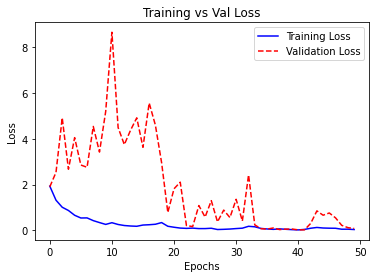

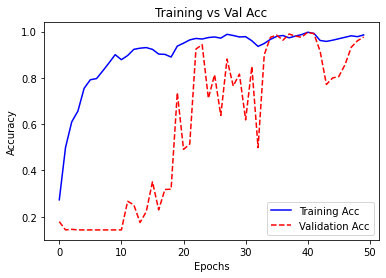

In [32]:
plot_results(model_history)

In [33]:
def display_classifcation_report(model, test_dataflow):
    predictions = model.predict(test_dataflow)
    predictions = np.argmax(predictions, axis = -1)
    y_test = test_dataflow.labels
    print(classification_report(y_test, predictions, target_names = emotions))

In [34]:
display_classifcation_report(model,test_dataflow)

              precision    recall  f1-score   support

       ANGRY       0.78      0.89      0.83        28
     FEARFUL       0.91      0.75      0.82        28
   DISGUSTED       0.79      0.54      0.64        28
       HAPPY       0.96      0.82      0.88        28
         SAD       0.80      0.71      0.75        28
   SURPRISED       0.52      0.89      0.66        28
     NEUTRAL       1.00      0.89      0.94        28

    accuracy                           0.79       196
   macro avg       0.82      0.79      0.79       196
weighted avg       0.82      0.79      0.79       196



In [35]:
model.save('kdef_model.h5')

In [53]:
def to_grayscale(image):
    image = tf.image.rgb_to_grayscale(image)
    #image = tf.image.grayscale_to_rgb(image)
    return image

In [54]:
train_gray_datagen = ImageDataGenerator(horizontal_flip=True,preprocessing_function=to_grayscale,validation_split=0.1, rescale=1./255)
test_gray_datagen = ImageDataGenerator(rescale=1./255,preprocessing_function=to_grayscale)

In [55]:
train_gray_dataflow = train_datagen.flow_from_directory(KDEF_TRAIN_PATH, target_size=(48,48),color_mode = 'grayscale')
test_gray_dataflow = test_datagen.flow_from_directory(KDEF_TEST_PATH, target_size=(48,48), shuffle=False, color_mode = 'grayscale')

Found 784 images belonging to 7 classes.
Found 196 images belonging to 7 classes.


In [56]:
model_gray = Sequential([
    Conv2D(512, (3,3), input_shape=(48,48,1),activation = 'relu'),
    MaxPool2D(),
    BatchNormalization(),
    Conv2D(512,(3,3), activation = 'relu'),
    MaxPool2D(),
    BatchNormalization(),
    Conv2D(256,(3,3), activation = 'relu'),
    MaxPool2D(),
    BatchNormalization(),
    Conv2D(256,(3,3), activation = 'relu'),
    MaxPool2D(),
    BatchNormalization(),
    Flatten(),
    Dense(512,activation = 'relu'),
    Dropout(0.2),
    Dense(256,activation = 'relu'),
    Dense(7,activation = 'softmax')
])

In [57]:
model_gray.compile(loss = 'categorical_crossentropy' , 
              metrics = ['acc'],
             optimizer = tf.keras.optimizers.Adam())

In [58]:
model_gray.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 46, 46, 512)       5120      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 23, 23, 512)      0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 23, 23, 512)      2048      
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 21, 21, 512)       2359808   
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 10, 10, 512)      0         
 2D)                                                             
                                                      

In [62]:
model_gray_history = model_gray.fit(train_gray_dataflow,validation_data=train_gray_dataflow, epochs =50)

Epoch 1/50
25/25 [==============================] - 7s 257ms/step - loss: 0.0855 - acc: 0.9694 - val_loss: 0.1283 - val_acc: 0.9541
Epoch 2/50
25/25 [==============================] - 6s 257ms/step - loss: 0.0563 - acc: 0.9809 - val_loss: 0.1209 - val_acc: 0.9605
Epoch 3/50
25/25 [==============================] - 6s 256ms/step - loss: 0.0448 - acc: 0.9783 - val_loss: 0.0915 - val_acc: 0.9643
Epoch 4/50
25/25 [==============================] - 7s 266ms/step - loss: 0.0256 - acc: 0.9923 - val_loss: 0.3625 - val_acc: 0.8916
Epoch 5/50
25/25 [==============================] - 7s 266ms/step - loss: 0.0297 - acc: 0.9898 - val_loss: 0.0363 - val_acc: 0.9923
Epoch 6/50
25/25 [==============================] - 7s 267ms/step - loss: 0.0158 - acc: 0.9936 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 7/50
25/25 [==============================] - 6s 259ms/step - loss: 0.0177 - acc: 0.9949 - val_loss: 0.0168 - val_acc: 0.9949
Epoch 8/50
25/25 [==============================] - 6s 261ms/step - loss: 0.

In [63]:
model_gray.evaluate(test_gray_dataflow)

7/7 [==============================] - 1s 111ms/step - loss: 0.8717 - acc: 0.8010


[0.8717197775840759, 0.8010203838348389]

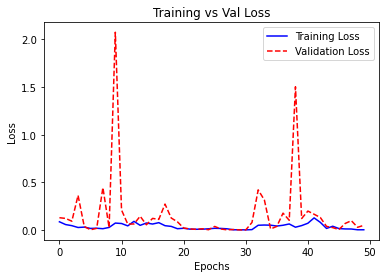

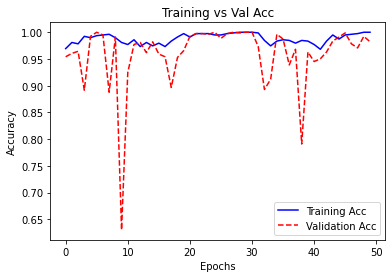

In [64]:
plot_results(model_gray_history)

In [66]:
display_classifcation_report(model_gray,test_gray_dataflow)

              precision    recall  f1-score   support

       ANGRY       0.81      0.89      0.85        28
     FEARFUL       0.92      0.86      0.89        28
   DISGUSTED       0.64      0.82      0.72        28
       HAPPY       0.96      0.89      0.93        28
         SAD       0.89      0.61      0.72        28
   SURPRISED       0.59      0.71      0.65        28
     NEUTRAL       0.96      0.82      0.88        28

    accuracy                           0.80       196
   macro avg       0.82      0.80      0.80       196
weighted avg       0.82      0.80      0.80       196



In [65]:
model_gray.save("kdef_gray_model.h5")